## 決定木を一から書いてみる
参考: 
- http://hktech.hatenablog.com/entry/2018/10/05/004235

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.base import BaseEstimator, ClassifierMixin

### 不純度
不純度としてGini係数を用いる。
ノード$t$でのクラス$C_i$の割合を$P^2(C_i|t)$とする。
Gini係数は
$$
\mathrm{Gini}(t) =  1 - \sum_{i=1}^{K} P^2(C_i|t)
$$
と書ける。

今回は実数閾値による分割ルールを考える。
分割ルールのスコアは子ノードのGini係数をその分割されたデータ数の重みつき和で計算する。
$$
\mathrm{score}(t) = \frac{|D_1|}{|D|}\mathrm{Gini}(t_1)  + \frac{|D_2|}{|D|}\mathrm{Gini}(t_2) 
$$

In [23]:
def gini_index(target):
    """
    閾値で分けた後の子について、クラスの割合を計算する
    """
    acc = 0.0
    for cls in np.unique(target):
        p = np.count_nonzero(target == cls) / len(target)
        acc += p * p

    return 1 - acc

def gini_score(data, target, feat_idx, threshold):
    """
    data: 対象データ
    target: 各データの教師ラベル
    feat_idx: 注目するインデックス
    threshold: 閾値
    """
    n = len(target)
    
    upper_bool_idx = data[:, feat_idx] >= threshold
    upper, lower = target[upper_bool_idx], target[~upper_bool_idx]
    
    return (gini_index(upper)*len(upper) + gini_index(lower)*len(lower)) / n    

## 不純度が最低になる閾値を探索

In [77]:
def find_threshold(data, target):
    thresh = best_f = None
    min_score = 1
    
    for feat_idx in range(data.shape[1]):
        for val in data[:, feat_idx]:
            score = gini_score(data, target, feat_idx, val)
            if min_score > score:
                min_score = score
                thresh = val
                best_f = feat_idx
    
    return thresh, best_f        

## 決定木のノード

In [78]:
class DTNode(object):
    def __init__(self, left, right, threshold, feature, gini, label, bin, depth):
        self.left = left
        self.right = right
        
        self.threshold = threshold
        self.feature = feature
        self.gini = gini
        self.label = label
        self.depth = depth
        self.bin = bin 
        
    def __repr__(self):
        if self.left is None and self.right is None:
            return f"<@{self.depth} {self.gini} {self.bin};{self.label}>"
        else:
            return f"(@{self.depth} x[{self.feature}]>={self.threshold}|{self.gini} {self.bin})[\n{self.left}][\n{self.right}]"

## 自作決定木学習機

In [79]:
class MyDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.tree = None
    
    def fit(self, data, target):
        class_num = len(np.unique(target))
        def make_node(data, target, depth):
            label = np.argmax(np.bincount(target))
            bin = np.zeros(class_num, dtype=np.int)
            bc = np.bincount(target)
            bin[0:len(bc)] = bc
            left_node = right_node = None
            
            # 深さ制限
            if self.max_depth == depth:
                return DTNode(left_node, right_node, None, None, gini_index(target), 
                              label, bin, depth)
            #  純粋
            elif not np.any(target - target[0]):
                return DTNode(left_node, right_node, None, None, 0, 
                              label, bin, depth)
            else:
                thresh, best_f = find_threshold(data, target)
                idx_left = data[:, best_f] >= thresh

                left_node = make_node(data[idx_left], target[idx_left], depth+1)
                right_node = make_node(data[~idx_left], target[~idx_left], depth+1)

                return DTNode(left_node, right_node, thresh, best_f, gini_index(target), label, bin, depth)
        
        self.tree = make_node(data, target, 1)
        return self
    
    def predict(self, data):
        def inner(tree, bool_idx, pred):
            if tree.left is None and tree.right is None:
                pred[bool_idx] = tree.label
                return pred
            else:
                left_idx = (data[:, tree.feature] >= tree.threshold) & bool_idx
                right_idx = (~left_idx) & bool_idx
                inner(tree.left, left_idx, pred)
                inner(tree.right, right_idx, pred)
                return pred
            
        size = data.shape[0]
        return inner(self.tree, np.ones(size, dtype=bool), np.empty(size))

In [80]:
iris = load_iris()
data = iris.data
target = iris.target

In [81]:
dt = MyDecisionTree(4)

In [82]:
dt.fit(data, target)
acc = dt.score(data, target)
print(acc)
dt.tree

0.9733333333333334


(@1 x[2]>=3.0|0.6666666666666667 [50 50 50])[
(@2 x[3]>=1.8|0.5 [ 0 50 50])[
(@3 x[2]>=4.9|0.04253308128544431 [ 0  1 45])[
<@4 0.0 [ 0  0 43];2>][
<@4 0.4444444444444444 [0 1 2];2>]][
(@3 x[2]>=5.0|0.16803840877914955 [ 0 49  5])[
<@4 0.4444444444444444 [0 2 4];2>][
<@4 0.04079861111111116 [ 0 47  1];1>]]][
<@2 0 [50  0  0];0>]

## プロット

In [83]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [84]:
np.unique(target)

array([0, 1, 2])

In [96]:
bl_idx = np.isin(target, [0,1,2])
data01 = data[bl_idx, 0:2]
target01 = target[bl_idx]

In [102]:
dt = MyDecisionTree(6)
dt.fit(data01, target01)
acc = dt.score(data01, target01)

print(dt)
dt.tree

MyDecisionTree(max_depth=6)


(@1 x[0]>=5.5|0.6666666666666667 [50 50 50])[
(@2 x[0]>=6.2|0.5458142440649729 [ 5 44 49])[
(@3 x[0]>=7.1|0.4125619834710743 [ 0 16 39])[
<@4 0 [ 0  0 12];2>][
(@4 x[1]>=2.5|0.4672796106003245 [ 0 16 27])[
(@5 x[0]>=7.0|0.44973230220107074 [ 0 14 27])[
<@6 0.0 [0 1 0];1>][
<@6 0.43875 [ 0 13 27];2>]][
<@5 0 [0 2 0];1>]]][
(@3 x[1]>=3.5|0.5083829096809085 [ 5 28 10])[
<@4 0 [5 0 0];0>][
(@4 x[0]>=5.8|0.38781163434903054 [ 0 28 10])[
(@5 x[1]>=3.2|0.47165532879818595 [ 0 13  8])[
<@6 0.0 [0 2 0];1>][
<@6 0.48753462603878117 [ 0 11  8];1>]][
(@5 x[0]>=5.6|0.20761245674740492 [ 0 15  2])[
<@6 0.2777777777777777 [ 0 10  2];1>][
<@6 0.0 [0 5 0];1>]]]]][
(@2 x[1]>=2.9|0.2374260355029585 [45  6  1])[
(@3 x[0]>=5.4|0.04345679012345682 [44  1  0])[
(@4 x[1]>=3.4|0.2777777777777777 [5 1 0])[
<@5 0 [5 0 0];0>][
<@5 0 [0 1 0];1>]][
<@4 0 [39  0  0];0>]][
(@3 x[0]>=4.9|0.44897959183673464 [1 5 1])[
(@4 x[0]>=5.0|0.2777777777777777 [0 5 1])[
<@5 0 [0 4 0];1>][
(@5 x[1]>=2.5|0.5 [0 1 1])[
<@6 0.0 [0 0

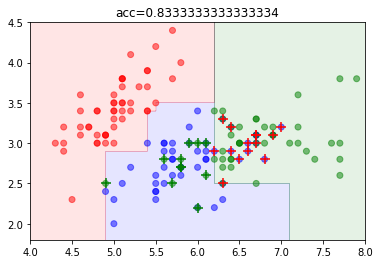

In [101]:
cmap = ListedColormap(('red', 'blue', 'green' ))
x_min, x_max = 4.0, 8.0
y_min, y_max = 1.8, 4.5
xx = np.linspace(x_min, x_max, 500)
yy = np.linspace(y_min, y_max, 500)
x_mesh, y_mesh = np.meshgrid(xx, yy)
z = dt.predict(np.array([x_mesh.ravel(), y_mesh.ravel()]).T).reshape(x_mesh.shape)
plt.contourf(xx, yy, z, alpha=0.1, cmap=cmap)
plt.scatter(data01[:, 0], data01[:, 1], c=target01, cmap=cmap, alpha=0.5)
plt.title(f"acc={acc}")
# fail
fail_idx = (target01 != dt.predict(data01))
plt.scatter(data01[fail_idx, 0], data01[fail_idx, 1], c=target01[fail_idx], cmap=cmap, 
            marker='+', s=100)

In [75]:
dt.predict(np.array([[3.1, 5]]))

1
2
3
3
2
3
4
5
5
4
3
4
4


array([0.])